### 线性回归（简化模型）

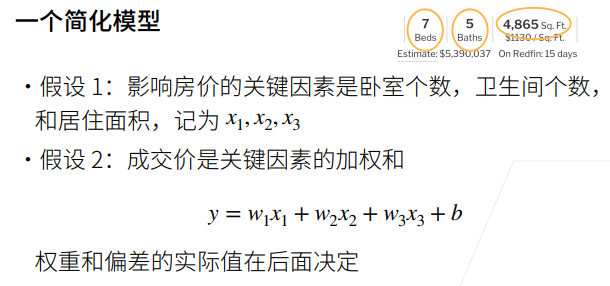

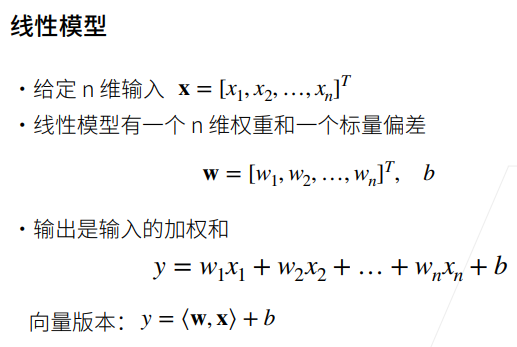

### 神经网络

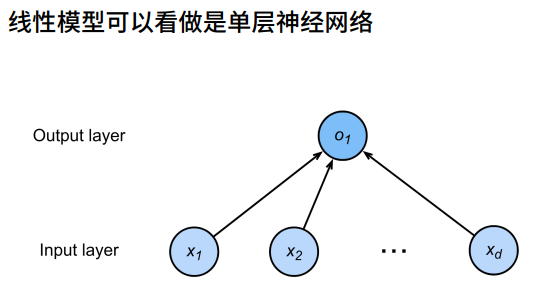

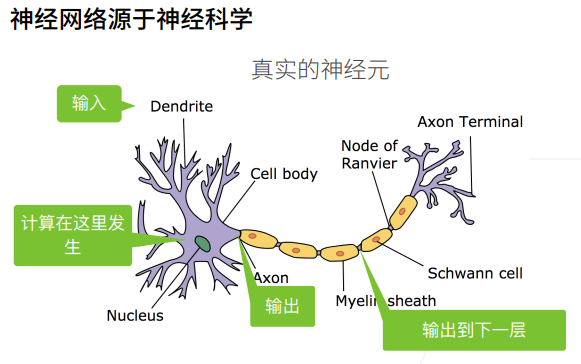

### 线性回归（求最优解）

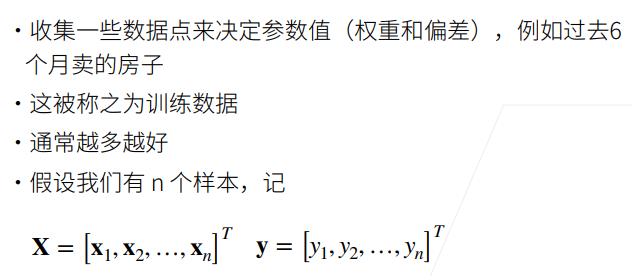

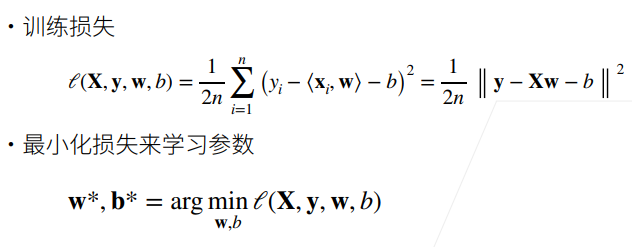

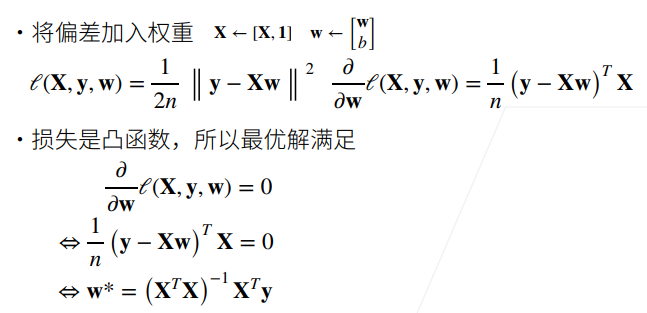

### 线性回归（总结）

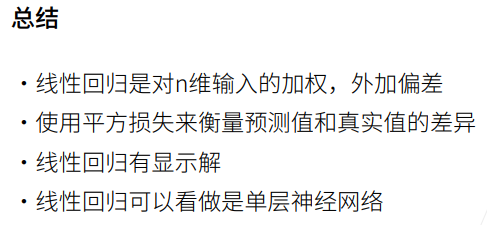

### 优化方法

>梯度下降法

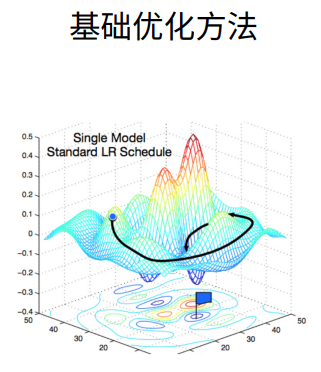

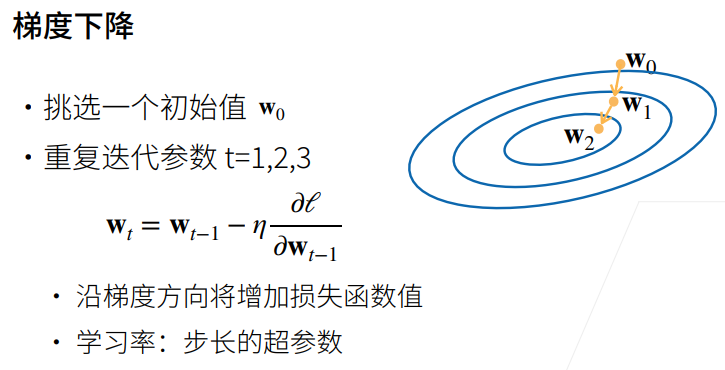

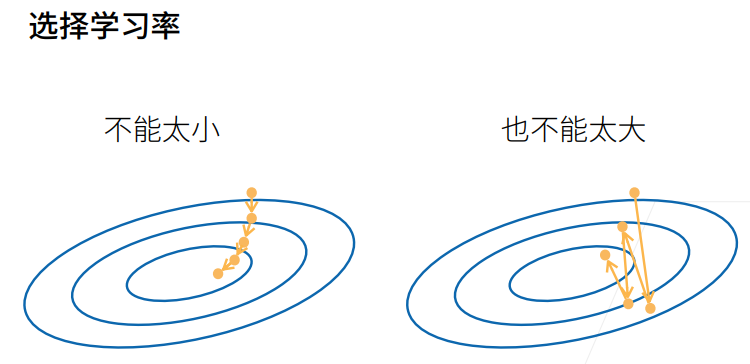

>小批量随即梯度下降法

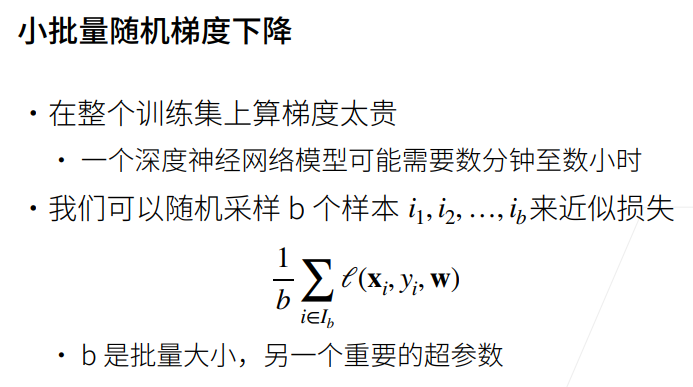

>选择批量大小

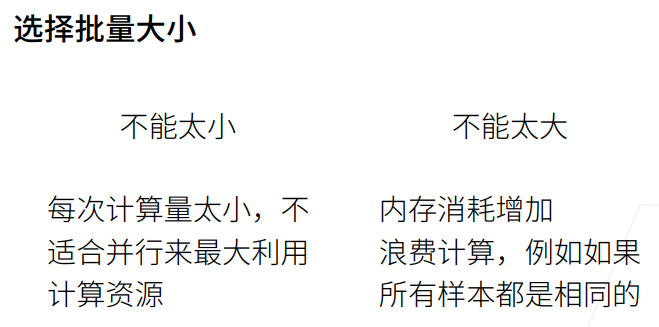

>总结

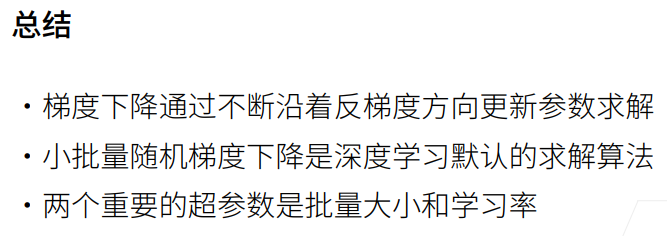

* 使用 .dot 的情况：
    * 计算向量点积（特别是明确想要标量结果时）
    * 简单的二维矩阵乘法（但 .matmul 同样可以）
* 使用 .matmul 的情况（更推荐）：
    * 批量矩阵乘法（深度学习中最常见）
    * 需要广播功能时
    * 高维数组的矩阵乘法
    * 在 PyTorch 中，使用 @ 运算符（等价于 matmul）

# 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。使用线性模型参数$w=[2,−3.4]^⊤$、$b=4.2$和噪声项ϵ生成数据集及其标签：$y=Xw+b+ϵ$

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, lables = synthetic_data(true_w, true_b, 1000)

In [3]:
print('features:', features[0], '\nlable:', lables[0])

features: tensor([1.0508, 0.0138]) 
lable: tensor([6.2493])


### 绘制数据集

features中每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标签）。

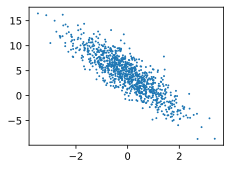

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), lables.detach().numpy(), 1) #只有detach后才能转到numpy里面去

### 读取小批量

In [6]:
def data_iter(batch_size, features, lables):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], lables[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, lables):
        print(X, '\n', y)
        break

tensor([[ 0.0098,  0.3741],
        [ 2.0761, -0.2581],
        [-0.0305, -1.2093],
        [ 0.7422, -1.0466],
        [-0.4021,  0.9811],
        [ 2.1780, -1.0795],
        [ 0.0845,  0.0237],
        [-0.4901, -1.1200],
        [-0.1350, -1.6732],
        [ 1.3496,  0.1962]]) 
 tensor([[ 2.9376],
        [ 9.2314],
        [ 8.2403],
        [ 9.2341],
        [ 0.0716],
        [12.2310],
        [ 4.2909],
        [ 7.0247],
        [ 9.6096],
        [ 6.2135]])


定义初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [8]:
def linreg(X, w, b):
    '''线性回归模型。'''
    return torch.matmul(X, w) + b

定义损失函数

In [9]:
def squared_loss(y_hat,y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [11]:
def sgd(params, lr, batch_size):
    """小批量梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, lables):
        l = loss(net(X, w, b), y) # 'X'和'y'的小批量损失
        # 因为l是形状是(batch_size,1)，而不是一个标量。l中所有元素被加到一起
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_1 = loss(net(features, w, b), lables)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')

epoch 1, loss 0.031813
epoch 2, loss 0.000113
epoch 3, loss 0.000052


In [14]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0004, -0.0006], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0002], grad_fn=<RsubBackward1>)


# 线性回归的简洁实现

In [1]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
from torch import nn    
    
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w,true_b,1000) # 库函数生成人工数据集    

# 调用框架现有的API来读取数据
def load_array(data_arrays,batch_size,is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays) # dataset相当于Pytorch的Dataset。一个星号*，表示对list解开入参。      
    return data.DataLoader(dataset,batch_size,shuffle=is_train) # 返回的是从dataset中随机挑选出batch_size个样本出来     

batch_size = 10
data_iter = load_array((features,labels),batch_size) # 返回的数据的迭代器
print(next(iter(data_iter))) # iter(data_iter) 是一个迭代器对象，next是取迭代器里面的元素  

# 使用框架的预定义好的层
# nn是神经网络的缩写
net = nn.Sequential(nn.Linear(2,1))

# 初始化模型参数
net[0].weight.data.normal_(0,0.01) # 使用正态分布替换掉weight变量里面的数据值
net[0].bias.data.fill_(0)  # 偏差bias变量里面的值设置为0
print(net[0])

# 计算均方误差使用的是MSELoss类，也称为平方L2范数
loss = nn.MSELoss()  #L1是算术差，L2是平方差

# 实例化SGD实例
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

# 训练过程代码与从零开始时所做的非常相似
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # 从DataLoader里面一次一次把所有数据拿出来
#         print("X:",X)
#         print("y:",y)
        l = loss(net(X),y) # net(X) 为计算出来的线性回归的预测值
        trainer.zero_grad() # 梯度清零
        l.backward()
        trainer.step()  # SGD优化器优化模型
    l = loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')

[tensor([[ 1.1346, -1.2164],
        [ 1.2709,  2.4922],
        [-0.3695, -0.2836],
        [ 0.4373, -0.3405],
        [-0.9475, -1.0081],
        [ 0.5527,  0.3787],
        [ 0.1497, -0.9464],
        [ 1.6826, -0.8032],
        [-0.2981, -0.0821],
        [ 0.6335,  0.4929]]), tensor([[10.6116],
        [-1.7331],
        [ 4.4420],
        [ 6.2311],
        [ 5.7335],
        [ 4.0165],
        [ 7.7157],
        [10.2864],
        [ 3.8826],
        [ 3.7919]])]
Linear(in_features=2, out_features=1, bias=True)
epoch1,loss0.000299
epoch2,loss0.000104
epoch3,loss0.000102


Softmax回归虽然它的名字是回归，其实它是一个分类问题。

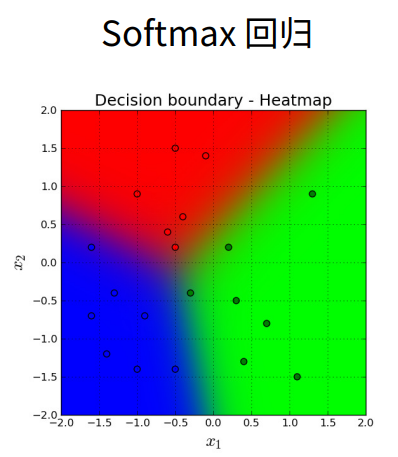

### 回归VS分类

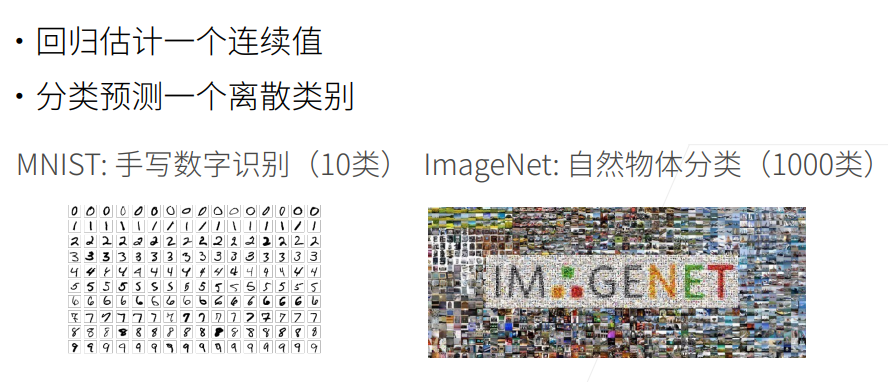

### Kaggle分类问题

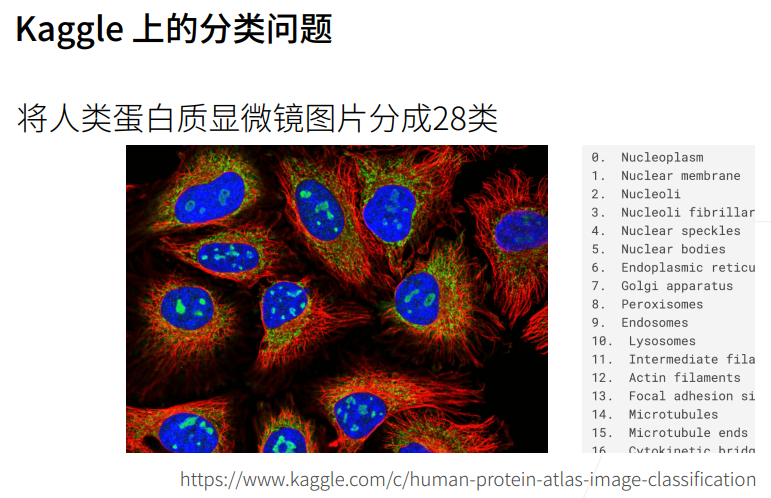
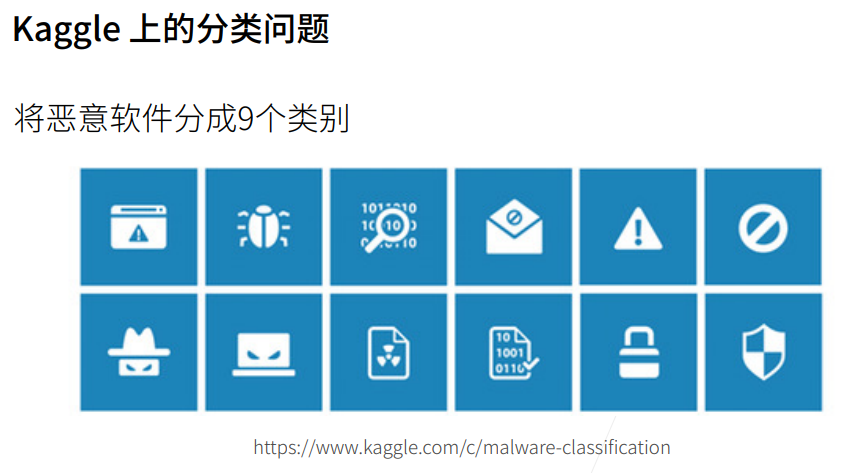
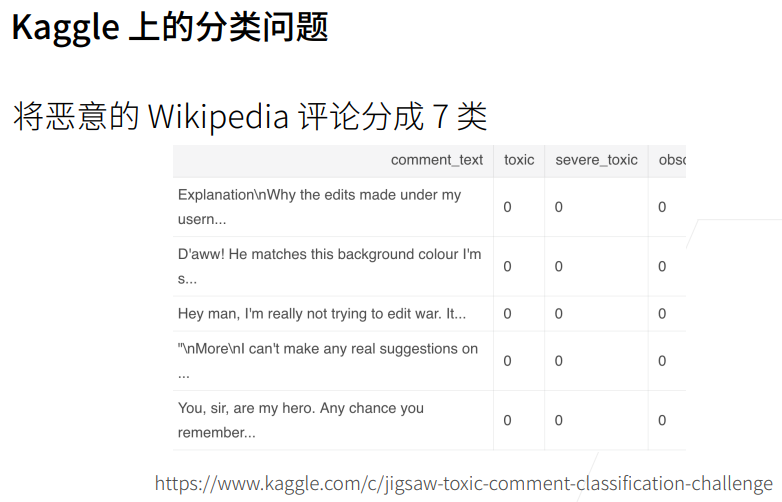

### 回归到分类

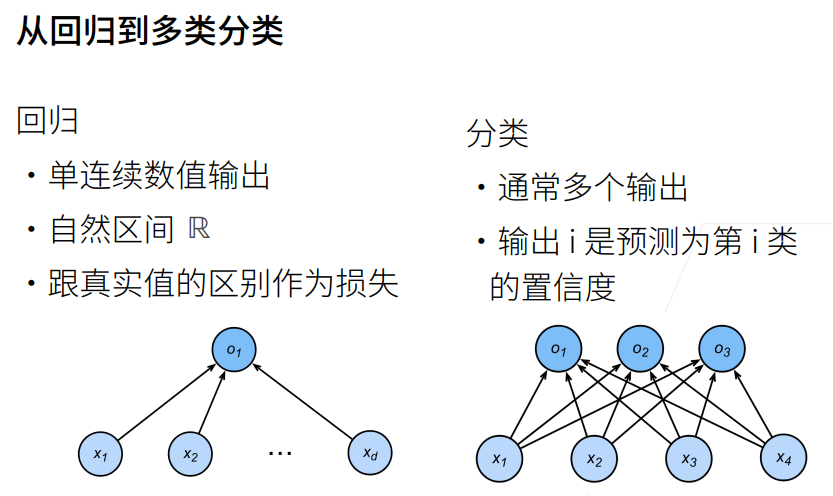
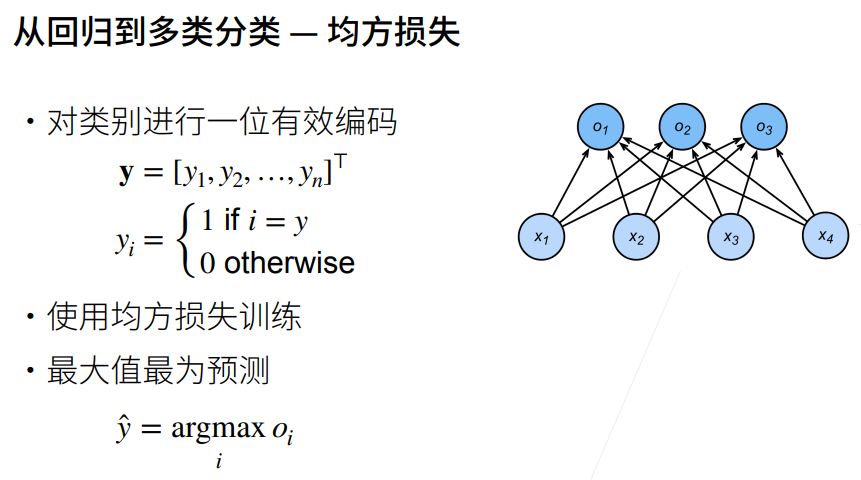
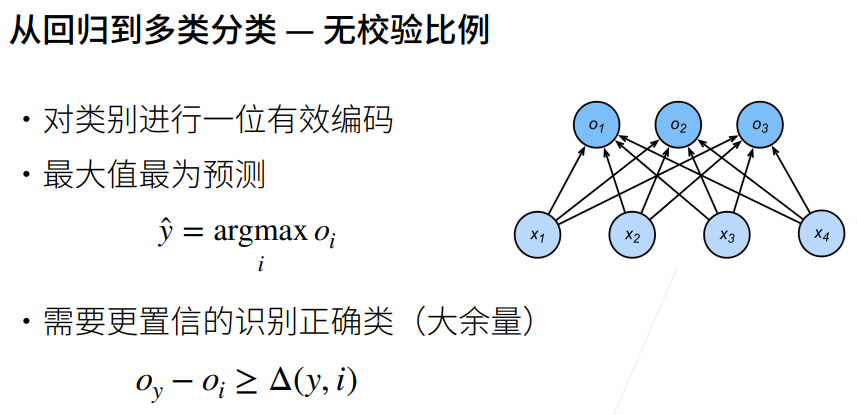
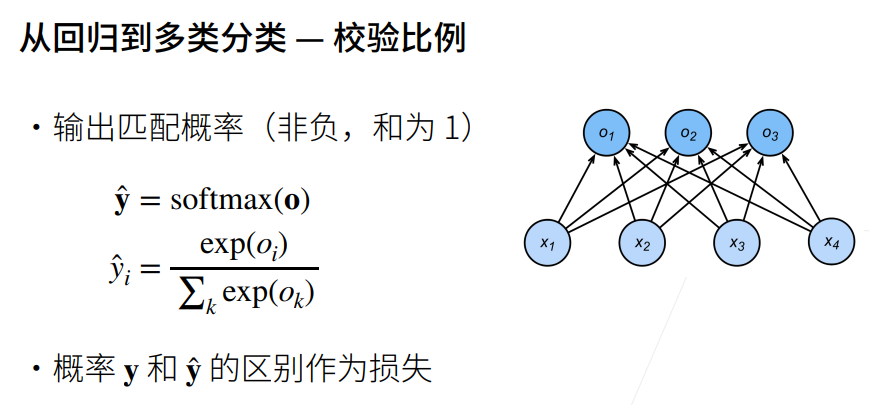

### 交叉熵损失

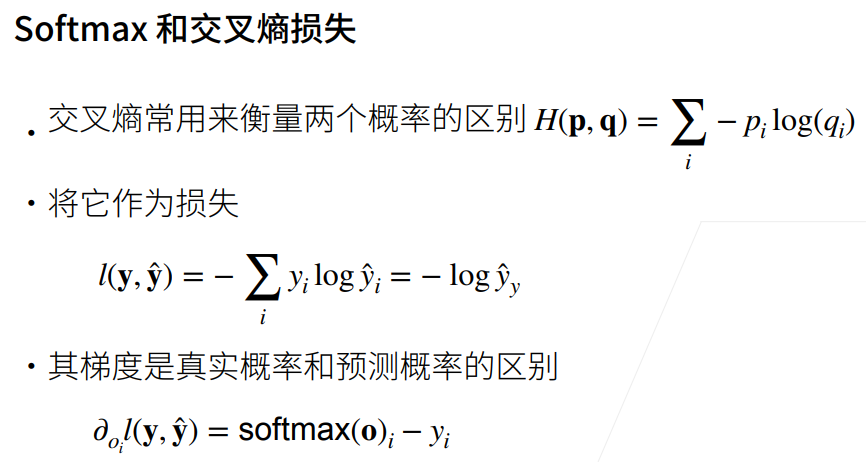

分类(本质是概率)用CrossEntropy

回归(本质是数值差)用MSE

### 总结

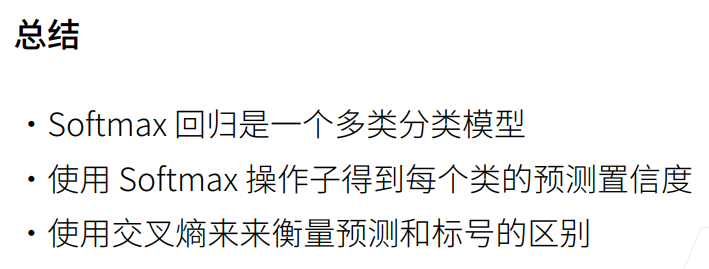

### 损失函数

三个常用的损失函数 L2 loss、L1 loss、Huber's Robust loss。

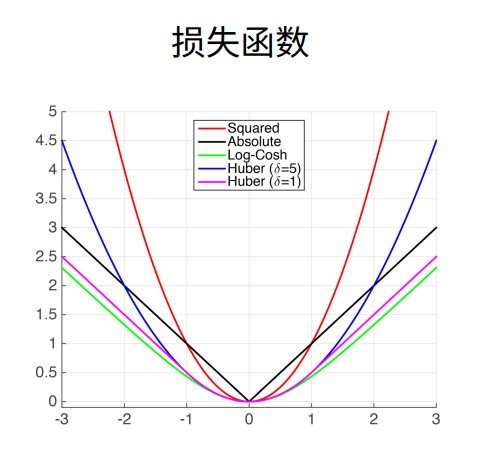

### L2 Loss

① 蓝色曲线为当y=0时，变换y'所获得的曲线。

② 绿色曲线为当y=0时，变换y'所获得的曲线的似然函数，即$1^{−l(y,y′)}$，似然函数呈高斯分布。最小化损失函数就是最大化似然函数。

③ 橙色曲线为损失函数的梯度，梯度是一次函数，所以穿过原点。

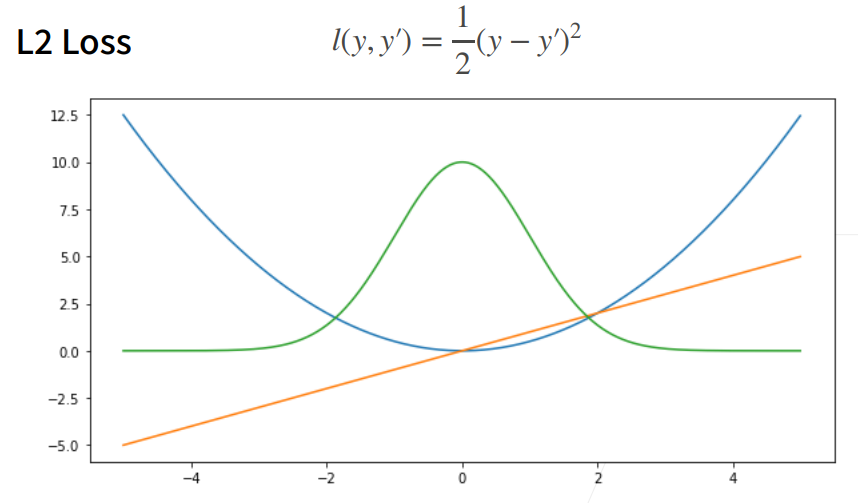

④ 当预测值y'跟真实值y隔的比较远的时候，(真实值y为0，预测值就是下面的曲线里的x轴)，梯度比较大，所以参数更新比较多。

⑤ 随着预测值靠近真实值是，梯度越来越小，参数的更新越来越小。

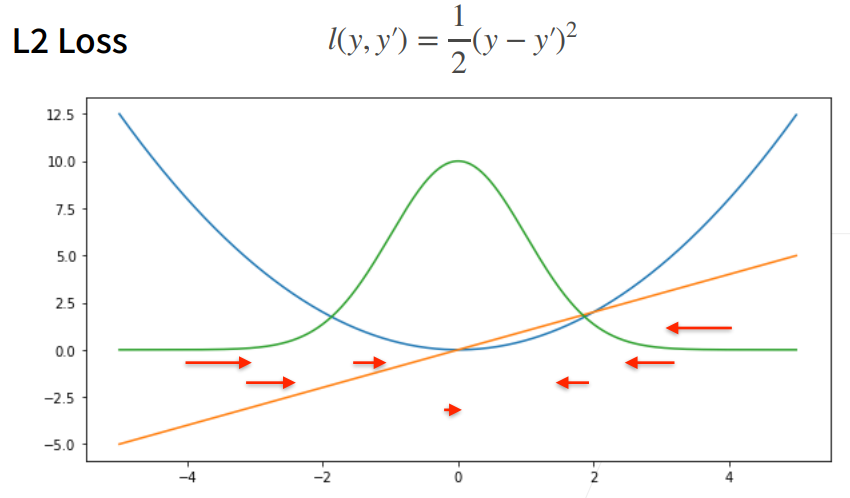

### L1 Loss

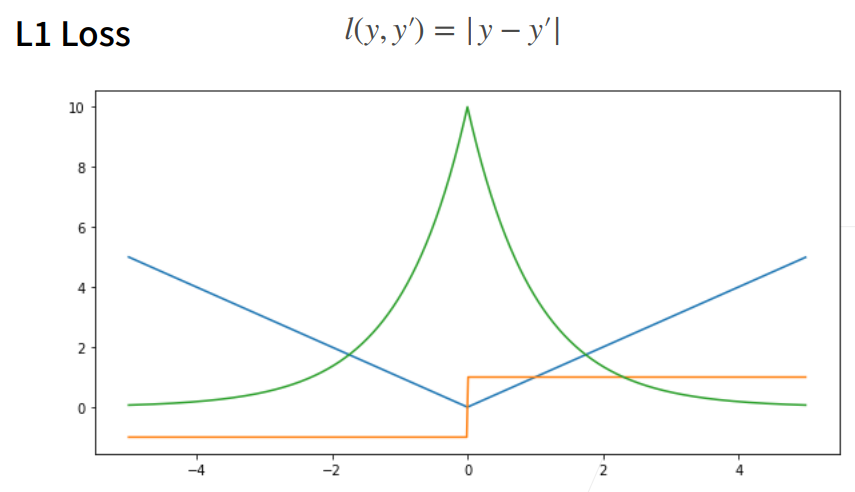

① 相对L2 loss，L1 loss的梯度就是距离原点时，梯度也不是特别大，权重的更新也不是特别大。会带来很多稳定性的好处。

② 他的缺点是在零点处不可导，并在零点处左右有±1的变化，这个不平滑性导致预测值与真实值靠的比较近的时候，优化到末期的时候，可能会不那么稳定。

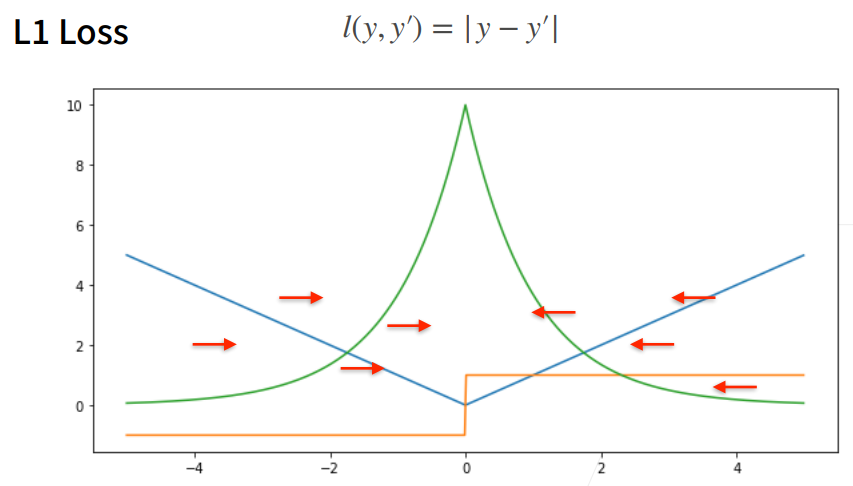

### Huber's Robust Loss

结合L1 loss 和L2 loss损失。

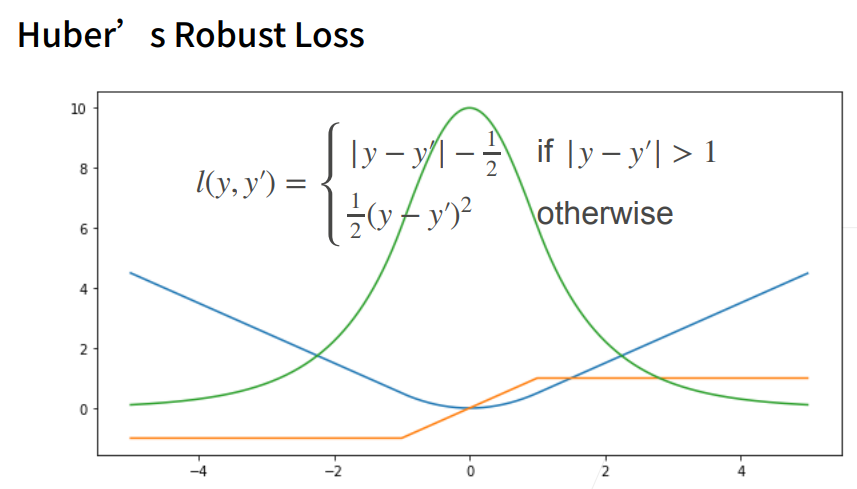

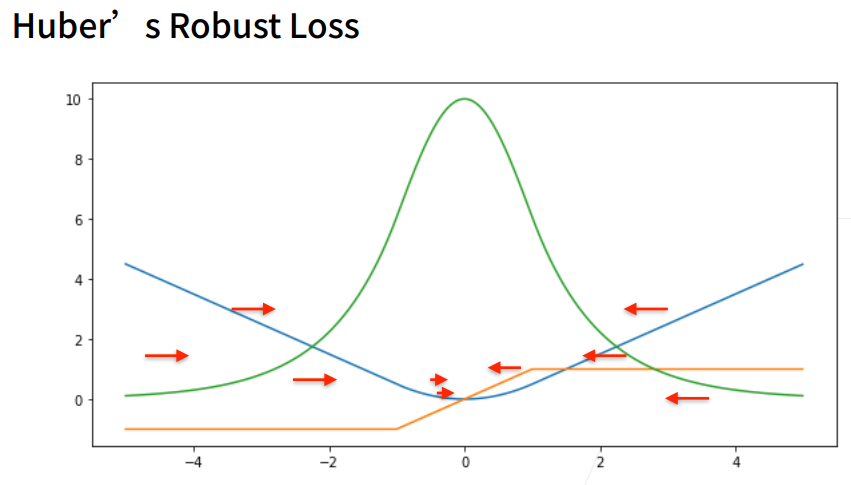

# 图像分类数据集

① MINIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。

② 下面将使用类似但更复杂的Fashion-MNIST数据集。

###### SVG是一种无损格式 – 意味着它在压缩时不会丢失任何数据，可以呈现无限数量的颜色。
###### SVG最常用于网络上的图形、徽标可供其他高分辨率屏幕上查看。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data/dataset_fashionmnist',train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data/dataset_fashionmnist',train=False,transform=trans,download=True)

len(mnist_train), len(mnist_test)

(60000, 10000)

In [3]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [4]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt','trouser','pullover','dress','coat',
                   'sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale) # 传进来的图像尺寸，scale 为放缩比例因子
    _, axes = d2l.plt.subplots(num_rows,num_cols,figsize=figsize)
    print(_)
    print(axes) # axes 为构建的两行九列的画布
    axes = axes.flatten()
    print(axes) # axes 变成一维数据
    for i,(ax,img) in enumerate(zip(axes,imgs)): # zip(axes, imgs)：将axes数组和图像列表配对
        if(i<1):                                 # enumerate()：同时获取索引和值
            print("i:",i)
            print("ax,img:",ax,img)
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
            ax.set_title(titles[i])
        else:
            # PIL图片
            ax.imshow(img)

Figure(1350x300)
[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
  <AxesSubplot:>]]
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
i: 0
ax,img: AxesSubplot(0.125,0.53;0.0731132x0.35) tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

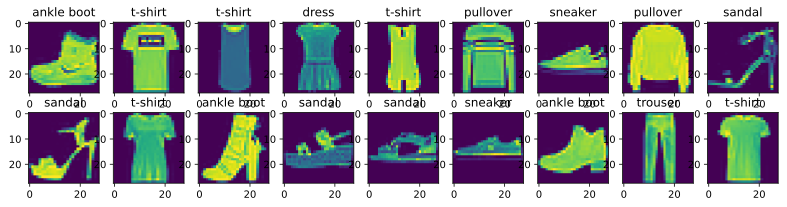

In [5]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18))) # X，y 为仅抽取一次的18个样本的图片、以及对应的标签值
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [6]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取的数据。"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'8.15 sec'

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize)) # 如果有Resize参数传进来，就进行resize操作
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data/dataset_fashionmnist",train=True,transform=trans,download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data/dataset_fashionmnist",train=False,transform=trans,download=True)            
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_workers()))

# Softmax回归的从零开始实现

In [8]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) # 返回训练集、测试集的迭代器 

###### ① 将展平每个图像，将它们视为长度784的向量。向量的每个元素与w相乘，所以w也需要784行。

###### ② 因为数据集有10个类别，所以网络输出维度为10.

In [9]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

① 给定一个矩阵X，可以对所有元素求和。

In [10]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

② 实现softmax：${softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}$

In [11]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition   # 这里应用了广播机制

In [12]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1180, 0.1089, 0.0913, 0.3608, 0.3210],
         [0.4177, 0.0671, 0.0108, 0.1380, 0.3664]]),
 tensor([1.0000, 1.0000]))

In [13]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)

### 交叉熵损失

① 创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引。

In [14]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

② 实现交叉熵损失函数。

In [16]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

③ 将预测类别与真实y元素进行比较。

In [17]:
len(y_hat)

2

In [18]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [19]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module): # 如果net模型是torch.nn.Module实现的神经网络的话，将它变成评估模式
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [20]:
# Accumulator实例中创建了2个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data, args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.0982

In [21]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train() # 开启训练模式
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): # 如果updater是pytorch的优化器的话
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel()) # 总的训练损失、样本正确数、样本总数
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [22]:
# 动画绘制
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g--', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)         
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [23]:
# 总训练函数        
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],       
                       legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):  # 变量num_epochs遍数据
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater) # 返回两个值，一个总损失、一个总正确率
        test_acc = evaluate_accuracy(net, test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率  
        animator.add(epoch + 1, train_metrics + (test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
    train_loss, train_acc = train_metrics

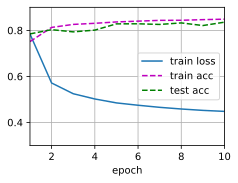

In [24]:
# 小批量随即梯度下降来优化模型的损失函数
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

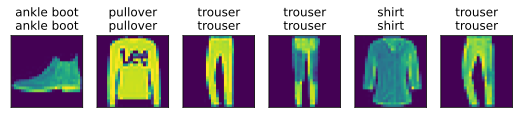

In [25]:
# 预测数据
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter: 
        break # 仅拿出一批六个数据
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

# Softmax回归的简洁实现

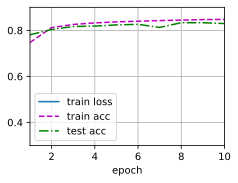

In [26]:
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display
import torchvision
from torchvision import transforms

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# Softmax回归的输出是一个全连接层
# PyTorch不会隐式地调整输入的形状
# 因此，我们定义了展平层(flatten)在线性层前调整网络输入的形状

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # 方差为0.01

net.apply(init_weights)
print(net.apply(init_weights)) # net网络的参数用的是init_weights初始化参数

# 在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss()
# 使用学习率为0.1的小批量随即梯度下降作为优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

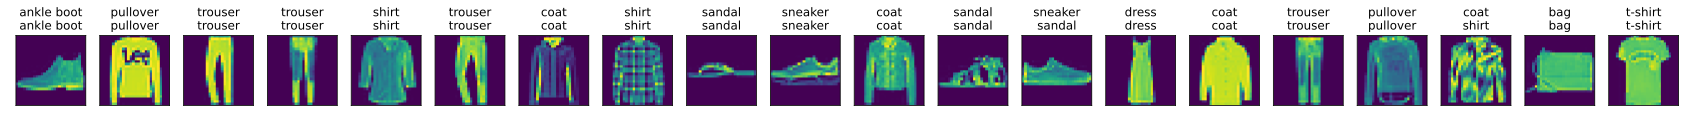

In [27]:
d2l.predict_ch3(net, test_iter, n=20)